# Short-term Plasticity

Download the Jupyter notebook: [STP.ipynb](https://raw.githubusercontent.com/ANNarchy/CNS2023/master/src/notebooks/STP.ipynb){target="_blank"} or run it directly on [colab.](https://colab.research.google.com/github/ANNarchy/CNS2023/blob/master/src/notebooks/STP.ipynb){target="_blank"}

In [1]:
#!pip install ANNarchy

The STP model is based on:

> Tsodyks, Uziel and Markram (2000). Synchrony Generation in Recurrent Networks with Frequency-Dependent Synapses, The Journal of Neuroscience, 20(50).

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ANNarchy import *
clear()
setup(dt=0.1)

ANNarchy 4.7 (4.7.2.5) on darwin (posix).


We will investigate a simple setup with one input neuron firing at a constant rate and one output neuron receiving spikes through a STP synapse.

The receiving neuron is a simple leaky integrate-and-fire:

In [3]:
LIF = Neuron(
    parameters = """
        tau = 10.0 : population
    """,
    equations = """
        tau * dv/dt = -v + g_exc : init=0.0
    """,
    spike = "v > 15.0",
    reset = "v = 0.0",
    refractory = 3.0
)


Short-term plasticity is defined by dynamical changes of synaptic efficiency, based on pre- or post-synaptic activity.

We define a STP synapse, whose post-pynaptic potential (psp, define by `g_target`) depends not only on the weight `w` and the emission of pre-synaptic spike, but also on intra-synaptic variables `x` and `u`.

The synaptic variables `x` and `u` generally follow linear ODEs:

$$\tau_\text{rec} \, \dfrac{d x(t)}{dt} + x(t) = 1$$
$$\tau_\text{facil} \, \dfrac{d u(t)}{dt} + u(t) = 0.1$$

When a pre-synaptic spike arrives at the synapse, the following updates are applied asynchronously:

$$x(t) \leftarrow (1 - u(t)) \times x(t)$$
$$u(t) \leftarrow u(t) + 0.1 \, (1 - u(t)) $$

and the post-synaptic conductance is increased from:

$$g(t) \leftarrow g(t) + w \, u(t) \, x(t)$$

In [4]:
STP = Synapse(
    parameters = """
        tau_rec = 10.0
        tau_facil = 10.0
        U = 0.1
    """,
    equations = """
        dx/dt = (1 - x)/tau_rec : init = 1.0, exponential
        du/dt = (U - u)/tau_facil : init = 0.1, exponential
    """,
    pre_spike="""
        g_target += w * u * x
        
        x *= (1 - u)
        u += U * (1 - u)
    """
)

The input population has one neuron that spikes regulary at 20 Hz (i.e. every 50 ms) for one second.

The projection uses the `STP` synapse.

In [5]:
# Input
inp = SpikeSourceArray(spike_times=[[50.*i for i in range(20)]])

# Output
pop = Population(geometry=1, neuron=LIF)

# Create projections
proj = Projection(pre=inp, post=pop, target='exc', synapse=STP)
proj.connect_all_to_all(weights=10.0) 

We compile and simulate for 10 seconds:

In [6]:
compile()

Compiling ...  OK 


We can record the postsynaptic membrane potential and the synaptic variables `u` and `v`:

In [7]:
m = Monitor(pop, ['v'])
n = Monitor(proj, ['x', 'u'])

We retrieve the recordings and plot them:

In [8]:
simulate(1100.0)

data_neuron = m.get()
data_synapse = n.get()

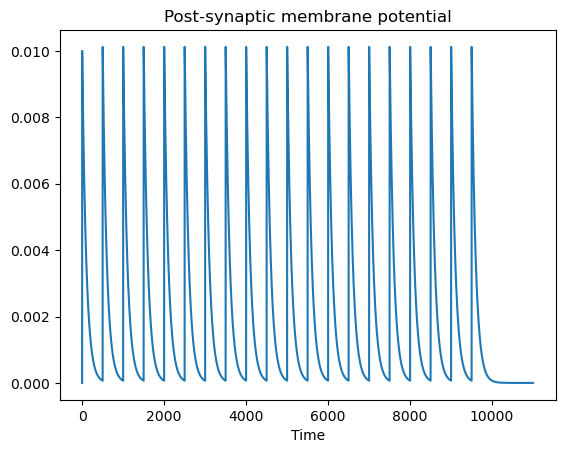

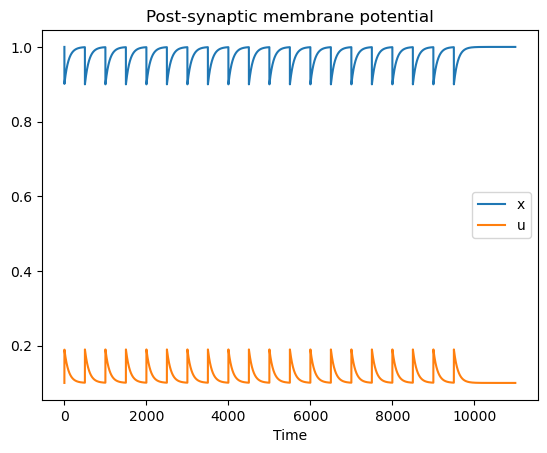

In [9]:
plt.figure()
plt.plot(data_neuron['v'])
plt.xlabel('Time')
plt.title('Post-synaptic membrane potential')

plt.figure()
plt.plot(data_synapse['x'][:, 0, 0], label='x')
plt.plot(data_synapse['u'][:, 0, 0], label='u')
plt.legend()
plt.xlabel('Time')
plt.title('Post-synaptic membrane potential')
plt.show()

**Experiments:**

1. With the default values of $\tau_\text{rec}$ and $\tau_\text{facil}$, there is no visible facilitating nor depressing effects in synaptic transmission. Increase their value (e.g. 100 ms or 1000 ms) and/or make them asymmetric to observe such effects.
2. Use the 'event-driven' numerical for 'x' and 'u'. What does it change to the recorded traces?